In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

class HiddenNaiveBayes:
    def __init__(self, epsilon=1e-6):  # Se puede ajustar de diferentes maneras el epsilon para mejorar o empeorar los resultados
        self.class_probs = {}
        self.cond_probs = defaultdict(dict)
        self.weights = defaultdict(dict)
        self.mutual_info = defaultdict(dict)
        self.hidden_parents = defaultdict(list)
        self.epsilon = epsilon

    def _calculate_class_probabilities(self, y):
        """Calcula las probabilidades de cada clase P(C) con M-estimación"""
        classes, counts = np.unique(y, return_counts=True)
        total_samples = len(y)
        k = len(classes)
        
        for c, count in zip(classes, counts):
            self.class_probs[c] = (count + self.epsilon / k) / (total_samples + self.epsilon)

    def _calculate_conditional_probabilities(self, X, y):
        """Calcula P(a_i | c) y P(a_i | a_j, c) usando M-estimación"""
        n_samples, n_features = X.shape
        classes = np.unique(y)
        
        for c in classes:
            class_filter = (y == c)
            for i in range(n_features):
                feature_values, counts = np.unique(X[class_filter, i], return_counts=True)
                total = np.sum(counts)
                n_i = len(feature_values)
                # Aplicando la M-estimación para P(a_i | c)
                self.cond_probs[(i, c)] = {val: (count + self.epsilon / n_i) / (total + self.epsilon) 
                                           for val, count in zip(feature_values, counts)}
                # Calcular P(a_i | a_j, c) para todos los pares de atributos (a_i, a_j)
                for j in range(n_features):
                    if i != j:
                        pair_counts = defaultdict(int)
                        for xi, xj in zip(X[class_filter, i], X[class_filter, j]):
                            pair_counts[(xi, xj)] += 1
                        total_pairs = sum(pair_counts.values())
                        n_ij = len(pair_counts)
                        # Suavizado Laplace similar al NB para P(a_i | a_j, c)
                        self.cond_probs[(i, j, c)] = {pair: (count + self.epsilon / n_ij) / (total_pairs + self.epsilon)
                                                      for pair, count in pair_counts.items()}
                        
    """Calcula la información mutua condicional IP(A_i; A_j | C)"""
    def _calculate_mutual_information(self, X, y):
        classes = np.unique(y)
        n_features = X.shape[1]
        
        for c in classes:
            for i in range(n_features):
                for j in range(n_features):
                    if i != j:
                        mi_sum = 0
                        for (a_i, a_j), p_aij_c in self.cond_probs[(i, j, c)].items():
                            p_ai_c = self.cond_probs[(i, c)].get(a_i, self.epsilon)
                            p_aj_c = self.cond_probs[(j, c)].get(a_j, self.epsilon)
                            mi_sum += p_aij_c * np.log(p_aij_c / (p_ai_c * p_aj_c))
                        self.mutual_info[(i, j, c)] = mi_sum
                        
    """Calcula los pesos W_ij usando la información mutua condicional"""
    def _calculate_weights(self, X, y):
        classes = np.unique(y)
        n_features = X.shape[1]
        
        for c in classes:
            for i in range(n_features):
                mi_sum = sum(self.mutual_info[(i, k, c)] for k in range(n_features) if k != i)
                for j in range(n_features):
                    if i != j:
                        self.weights[(i, j, c)] = (self.mutual_info[(i, j, c)] / mi_sum) if mi_sum != 0 else 0
                        if self.weights[(i, j, c)] > 0.15:  # Umbral para seleccionar padres ocultos
                            self.hidden_parents[i].append(j)
                            

    def fit(self, X, y):
        """Entrena el modelo calculando todas las probabilidades y pesos necesarios"""
        self._calculate_class_probabilities(y)
        self._calculate_conditional_probabilities(X, y)
        self._calculate_mutual_information(X, y)
        self._calculate_weights(X, y)

    def visualize_hidden_parents(self, feature_names=None):
        """
        Genera y visualiza un grafo de los padres ocultos basados en los pesos W_ij.
        Los pesos se muestran como etiquetas en las aristas.
        """
        G = nx.DiGraph()
        edge_labels = {}

        for child, parents in self.hidden_parents.items():
            for parent in parents:
                # Calcular el peso promedio solo para clases donde W_ij > umbral
                relevant_weights = [
                    self.weights.get((child, parent, c), 0) for c in self.class_probs.keys()
                    if self.weights.get((child, parent, c), 0) > 0.15
                ]

                if relevant_weights:  # Si hay pesos relevantes
                    avg_weight = np.mean(relevant_weights)
                    parent_name = f"Feature {parent}" if feature_names is None else feature_names[parent]
                    child_name = f"Feature {child}" if feature_names is None else feature_names[child]

                    # Agregar arista al grafo
                    G.add_edge(parent_name, child_name)
                    edge_labels[(parent_name, child_name)] = f"{avg_weight:.2f}"

        # Calcular la importancia de cada nodo
        importance = {node: {"in_degree": G.in_degree(node), "out_degree": G.out_degree(node)} for node in G.nodes}

        # Mostrar la importancia en consola
        print("Análisis de Importancia de Nodos:")
        for node, values in importance.items():
            print(f"{node} - Padres (in_degree): {values['in_degree']}, Hijos (out_degree): {values['out_degree']}")

        # Dibujar el grafo
        plt.figure(figsize=(17, 10))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, node_color="lightblue", edge_color="gray")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        plt.title("Hidden Parents Diagram (HNB) con Pesos Filtrados")
        plt.show()

    def _calculate_hidden_parent(self, a_i, i, X_sample, c):
        """
        Calcula P(a_i | Ahp_i, C) como una mezcla ponderada de las probabilidades condicionales
        de a_i dadas los demás atributos y la clase c.
        """
        weighted_sum = 0
        for j in range(len(X_sample)):
            if i != j:
                a_j = X_sample[j]
                weighted_sum += self.weights.get((i, j, c), 0) * self.cond_probs.get((i, j, c), {}).get((a_i, a_j), self.epsilon)
        
        # Aseguramos que la probabilidad no sea cero
        return max(weighted_sum, self.epsilon)
        
    def predict(self, X):
        """Predice la clase para cada muestra de X"""
        predictions = []

        for X_sample in X:
            class_scores = {}
            for c in self.class_probs:
                # Inicializar con P(C)
                score = np.log(self.class_probs[c])

                # Calcular la probabilidad combinada usando los padres ocultos
                for i in range(X_sample.shape[0]):
                    a_i = X_sample[i]
                    p_a_i_given_h = self._calculate_hidden_parent(a_i, i, X_sample, c)
                    score += np.log(p_a_i_given_h)

                class_scores[c] = score

            # Seleccionar la clase con la mayor puntuación
            best_class = max(class_scores, key=class_scores.get)
            predictions.append(best_class)

        return predictions
    
    def predict_probabilities(self, X):
        """Devuelve las probabilidades de clase para cada muestra de X"""
        probabilities = []
        all_classes = sorted(self.class_probs.keys())  # Todas las clases conocidas

        for X_sample in X:
            class_probs = {cls: 0 for cls in all_classes}  # Inicializar con 0 para todas las clases
            for c in self.class_probs:
                # Inicializar con P(C)
                score = np.log(self.class_probs[c])

                # Calcular la probabilidad combinada usando los padres ocultos
                for i in range(X_sample.shape[0]):
                    a_i = X_sample[i]
                    p_a_i_given_h = self._calculate_hidden_parent(a_i, i, X_sample, c)
                    score += np.log(p_a_i_given_h)

                class_probs[c] = np.exp(score)

            # Normalizar para que las probabilidades sumen 1
            total_prob = sum(class_probs.values())
            class_probs = {k: v / total_prob for k, v in class_probs.items()}

            # Asegurarse de que las probabilidades están en el mismo orden que all_classes
            probabilities.append([class_probs[cls] for cls in all_classes])

        return np.array(probabilities)

# Generación del Grafo de Padres Ocultos en Hidden Naive Bayes

En esta sección, se explica cómo funciona la generación del **grafo de padres ocultos** en el modelo Hidden Naive Bayes (HNB). Este grafo permite visualizar las relaciones de influencia entre los atributos de un conjunto de datos.

---

## **1. Construcción del Grafo**
La construcción del grafo se basa en las relaciones calculadas durante el entrenamiento del modelo HNB:

1. **Nodos:**
   - Cada nodo representa un atributo (o característica) del conjunto de datos.

2. **Aristas (Flechas):**
   - Las flechas dirigidas entre nodos representan relaciones entre los atributos.
   - Si un atributo $A_j$ tiene un peso significativo $(W_{ij} > umbral)$ como "padre oculto" de otro atributo $A_i$, se dibuja una flecha desde $A_j$ hacia $A_i$.

---

## **2. Proceso de Generación**

El grafo se genera con los siguientes pasos:

### **Paso 1: Cálculo de Padres Ocultos**
Durante el entrenamiento del modelo HNB:
- Se calculan los pesos $W_{ij}$ para cada par de atributos $A_i$ y $A_j$.
- Los pesos representan cuánto influye $A_j$ sobre $A_i$.
- Si $W_{ij}$ supera un umbral (por ejemplo, 0.2), $A_j$ se considera un padre significativo de $A_i$.

### **Paso 2: Creación del Grafo**
Se utiliza la biblioteca `networkx` para construir un grafo dirigido (`nx.DiGraph`):
- Cada nodo es un atributo.
- Cada flecha (arista) conecta un nodo padre con su nodo hijo.

### **Paso 3: Análisis de Importancia**
Se calcula:
- **`in_degree`:** Número de flechas que apuntan hacia un nodo. Indica cuántos atributos influyen en el nodo actual.
- **`out_degree`:** Número de flechas que salen de un nodo. Indica cuántos atributos están influenciados por el nodo actual.

### **Paso 4: Visualización**
El grafo se dibuja usando `matplotlib`:
- Los nodos se muestran con etiquetas (los nombres de los atributos).
- Las flechas indican relaciones de influencia.

---

## **3. Interpretación del Grafo**
### Relaciones más Fuertes:

- Los nodos con mayor in_degree dependen de muchos atributos.
- Los nodos con mayor out_degree influyen en muchos atributos.
### Simplicidad o Complejidad:

- Un grafo denso indica que las características están muy correlacionadas.
- Un grafo más disperso resalta relaciones clave.
### Toma de Decisiones:

- Se puede identificar los atributos más influyentes y reducir la complejidad eliminando atributos poco importantes.

In [7]:
# Ejemplo de uso con datos
data = pd.read_csv("C:\\Users\\Carlo\\Desktop\\IA\\tercer semestre\\teoria de la info\\bases de datos discretizadas bien\\mushroom_dis.csv")
#data = data.drop(columns=['id'])
#data.dropna(inplace=True) 

# Eliminar la última columna (variable objetivo)
class_column = data.columns[-1]  # Identificar la última columna

X = data.drop(columns=[class_column], axis=1).values
y = data[class_column].values

Análisis de Importancia de Nodos:
cap-color - Padres (in_degree): 0, Hijos (out_degree): 1
odor - Padres (in_degree): 2, Hijos (out_degree): 2
stalk-root - Padres (in_degree): 1, Hijos (out_degree): 1
habitat - Padres (in_degree): 0, Hijos (out_degree): 2
gill-size - Padres (in_degree): 2, Hijos (out_degree): 0
spore-print-color - Padres (in_degree): 0, Hijos (out_degree): 2
ring-number - Padres (in_degree): 1, Hijos (out_degree): 0
population - Padres (in_degree): 1, Hijos (out_degree): 0
gill-spacing - Padres (in_degree): 1, Hijos (out_degree): 0


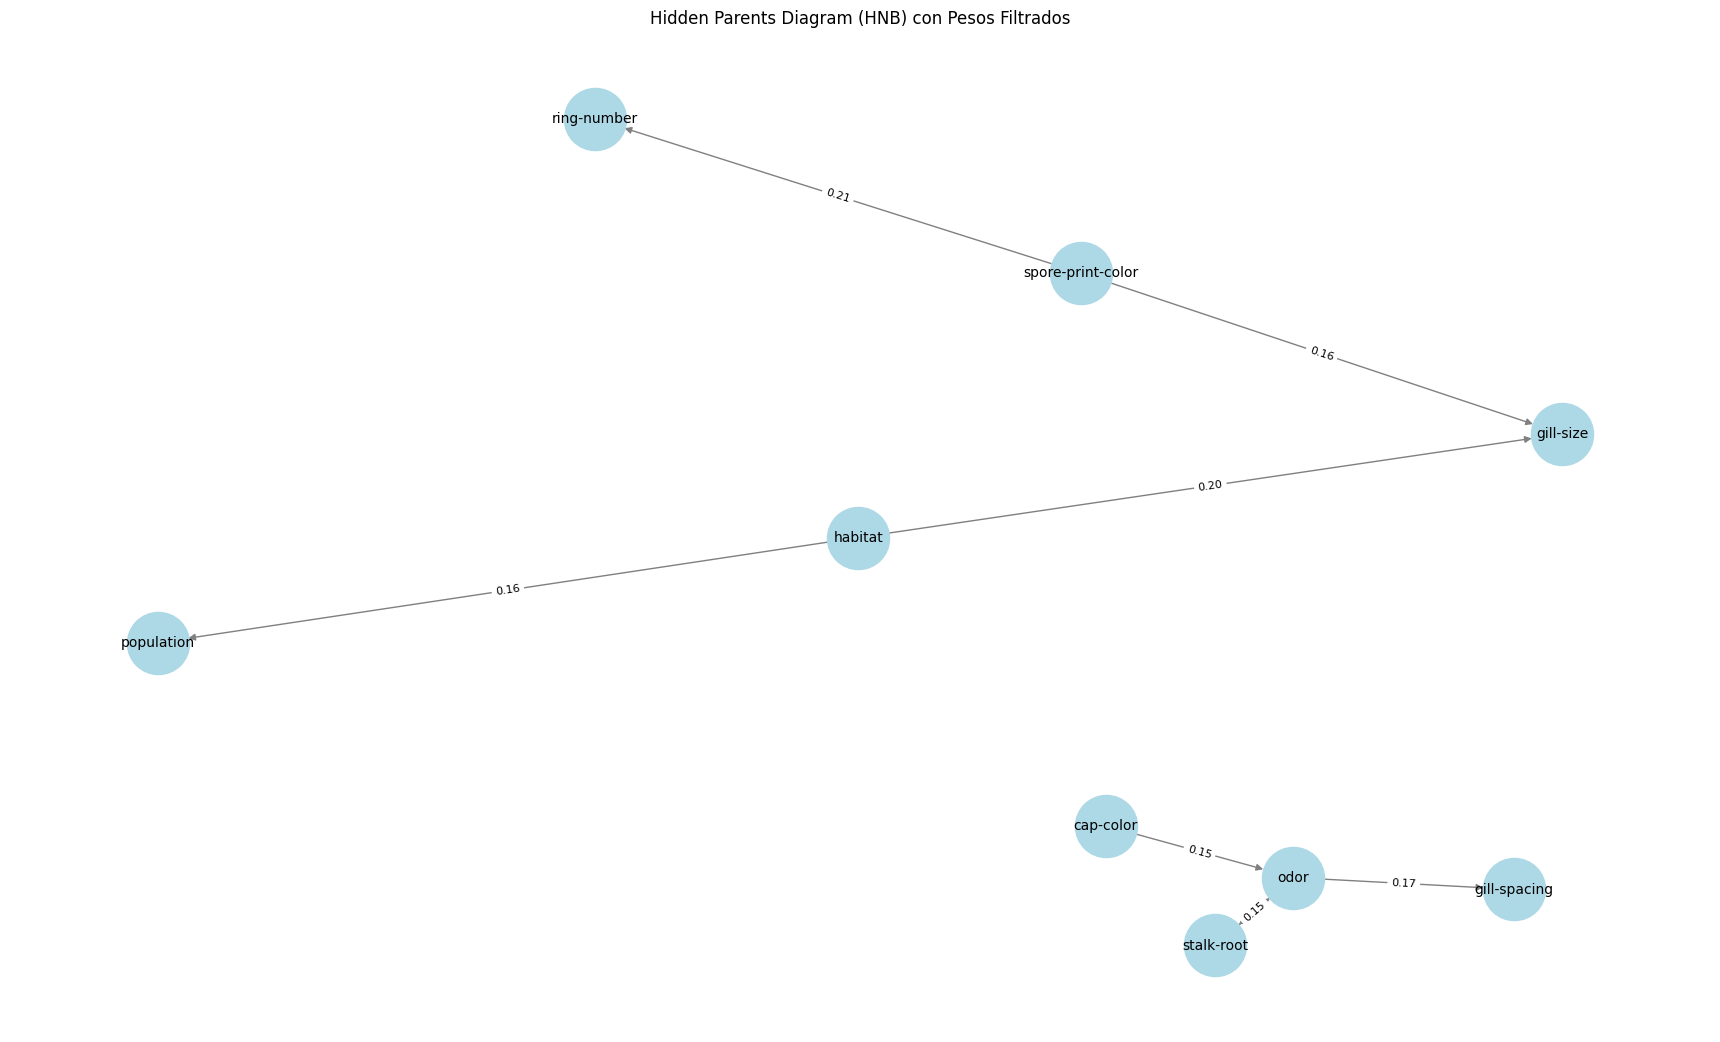

In [8]:
hnb = HiddenNaiveBayes()
hnb.fit(X, y)

# Visualizar el diagrama
hnb.visualize_hidden_parents(feature_names=data.drop(columns=[class_column], axis=1).columns)

In [4]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

def hnb_predict(hnb_model, X):
    return hnb_model.predict(X)

def calculate_metrics(y_true, y_pred, class_probs, all_classes):
    """
    Calcula las métricas de rendimiento: Precisión, AUC y Log-verosimilitud Condicional (CLL).
    Maneja casos en los que y_true tiene solo una clase.
    """
    # Calcular precisión
    accuracy = np.mean(y_true == y_pred)

    # Calcular Log-verosimilitud Condicional (CLL)
    cll = -log_loss(y_true, class_probs, labels=all_classes)

    return accuracy, cll


def hnb_simple_cross_validate(data, target, k=10):
    folds = np.array_split(data.sample(frac=1, random_state=42), k)  # Dividir datos en k partes aleatorias
    accuracies, clls = [], []
    all_classes = sorted(data[target].unique())  # Todas las clases posibles

    for i in range(k):
        # Dividir en entrenamiento y prueba
        train = pd.concat([folds[j] for j in range(k) if j != i])
        test = folds[i]

        # Entrenar el modelo Hidden Naive Bayes
        hnb_model = HiddenNaiveBayes()
        hnb_model.fit(train.drop(target, axis=1).values, train[target].values)

        # Predecir con el modelo entrenado
        X_test = test.drop(target, axis=1).values
        y_test = test[target].values
        predictions = hnb_model.predict(X_test)

        # Obtener probabilidades normalizadas
        class_probs = hnb_model.predict_probabilities(X_test)

        # Calcular métricas
        accuracy = np.mean(predictions == y_test)

        # Calcular log-loss
        try:
            cll = -log_loss(y_test, class_probs, labels=all_classes)
        except ValueError:
            cll = np.nan  # Si log_loss falla

        # Almacenar métricas
        accuracies.append(accuracy)
        clls.append(cll)

    # Retornar métricas promedio y desviaciones estándar
    return {
        "mean_accuracy": np.mean(accuracies),
        "std_accuracy": np.std(accuracies),
        "mean_cll": np.nanmean(clls),
        "std_cll": np.nanstd(clls),
    }

# Ejemplo de uso
results = hnb_simple_cross_validate(data, target=class_column, k=10)

# Mostrar resultados
print(f"Precisión media: {results['mean_accuracy']:.6f} ± {results['std_accuracy']:.6f}")
print(f"Log-verosimilitud media (CLL): {results['mean_cll']:.6f} ± {results['std_cll']:.6f}")

c:\Users\Carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Precisión media: 0.560823 ± 0.109659
Log-verosimilitud media (CLL): -6.257457 ± 2.626289
